In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band

# Try to load LaTeX
latex_flag = False
try:
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig, ax = newplot("full", use_tex = True)
    print("Loaded LaTeX")
    latex_flag = True
except:
    print("Could not load LaTeX")
    latex_flag = False  

latex_flag = False

np.seterr(divide='ignore')

Loaded LaTeX


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Error in callback <function _draw_all_if_interactive at 0x7f5e060d7670> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 510x510 with 1 Axes>

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [8]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 

# pickles contain all the results from the BDT training
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_2"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 50
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"
num_bins_SR = 16 # 16, 12, 8

pseudo_e_to_plot = 0
fit_type = "cubic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic


In [9]:
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

# Load in the original data

In [10]:
# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


## Load in the BDT results

In [11]:
# if train_samesign = False, this loads in the OS test data
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits_{fit_type}_{num_bins_SR}", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)

## Plot histograms for a small number of FPR thresholds

In [12]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


In [13]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, num_bins_SR, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        print(f"B expected: {num_B_expected_in_SR}. B error: {B_error}")
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")



    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (0.475, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    #plt.yscale("log")
    #plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    


B expected: 5733.633867627881. B error: 27.687329894765938
B expected: 1543.8577431561425. B error: 16.81823582974601
B expected: 664.3504837087968. B error: 9.110145318153672
B expected: 345.73968419237343. B error: 8.880439007773118


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

B expected: 74.39478712037946. B error: 3.417620369104877
B expected: 40.97948558539721. B error: 2.547243829165908
B expected: 3.8357485546580774. B error: 0.8633460290777726


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none

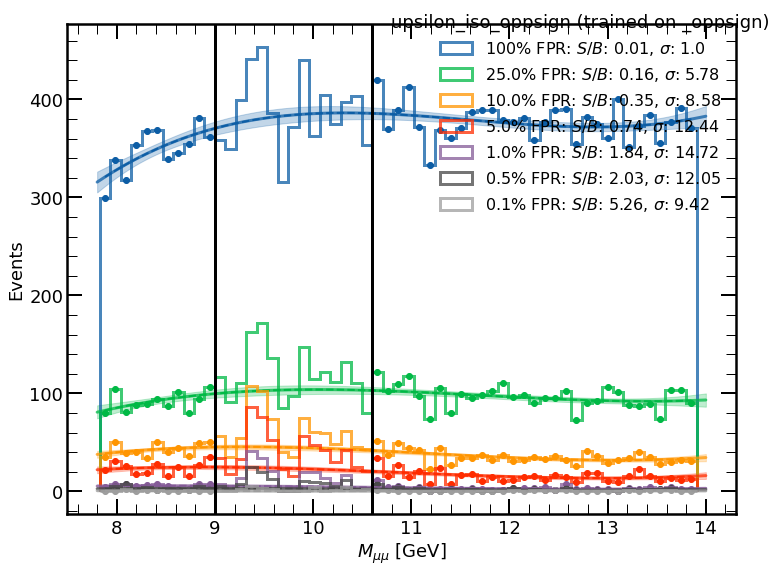

In [14]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], 
                          score_cutoffs[pseudo_e_to_plot], scaler, fit_type, num_bins_SR,
                          f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


B expected: 5638.1045328460705. B error: 31.815156213643554
B expected: 1401.679492842516. B error: 18.05213297781599
B expected: 559.5374687694581. B error: 9.594301415670017
B expected: 243.31446451544494. B error: 5.030116349827359


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

B expected: 22.854019619987575. B error: 1.9936146539064186
B expected: 13.238738307543453. B error: 1.7290341700057443
B expected: 3.699385223347935. B error: 0.6321530865058754


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

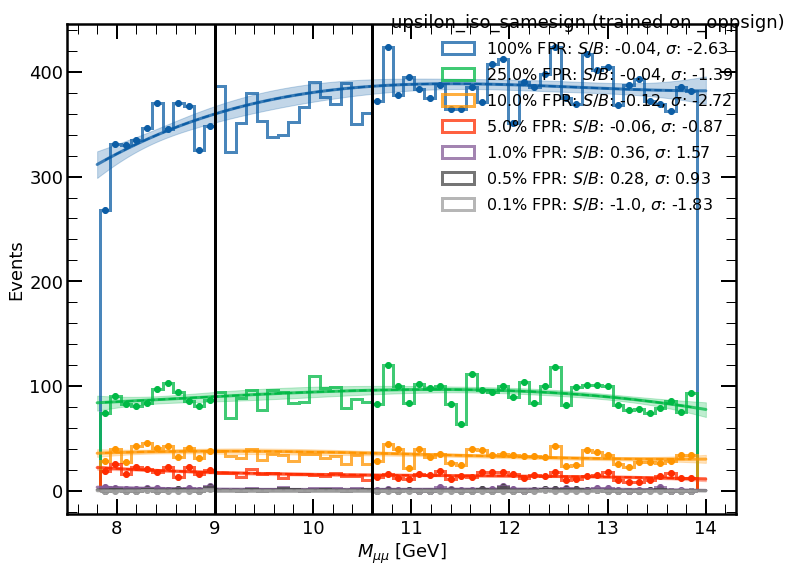

In [15]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], 
                          all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, 
                          fit_type, num_bins_SR,
                          f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, 
                          SR_left, SR_right, SB_right, take_score_avg=False)





In [16]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

B expected: 28658.972647732084. B error: 138.69718598852035
B expected: 7064.470567006531. B error: 37.066886261682434
B expected: 2848.556863647267. B error: 20.492091057066528
B expected: 1482.015351851803. B error: 16.52507379819592
B expected: 255.67776491727537. B error: 5.297746353698373
B expected: 126.42993522084937. B error: 4.145353632793164


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

B expected: 15.341311514156605. B error: 1.4897754206553724


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

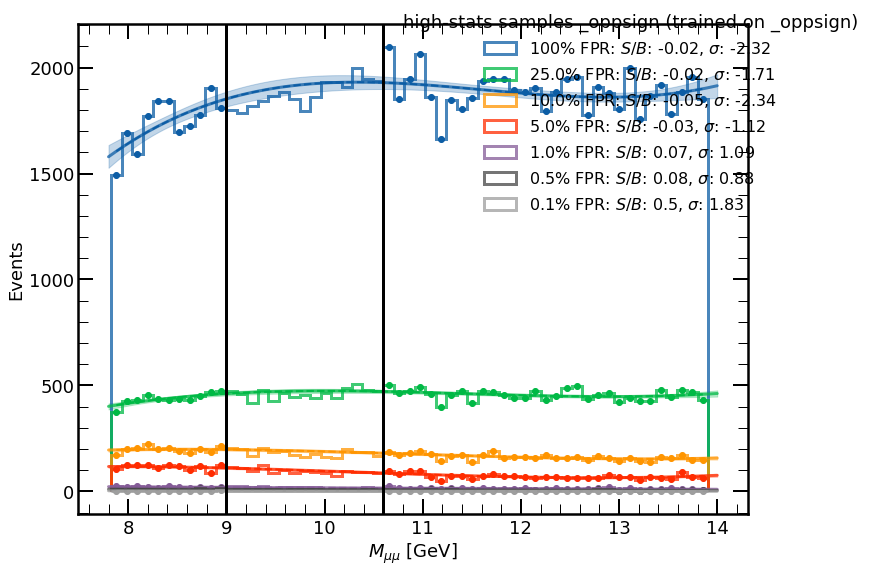

In [17]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], 
                          all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, 
                          fit_type,num_bins_SR,
                          f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Classical Studies

In [18]:
from helpers.plotting import feature_bins


def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, num_bins_SR, title, SB_left, SR_left, SR_right, SB_right, flip = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """

        

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):


        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))


        hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
        # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")




    legend_title = rf"Upsilon {feature}: Iso, Opp. Sign"
    plt.legend(loc = (0.475, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    



dimu_pt
mu0_ip3d
mu1_ip3d


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

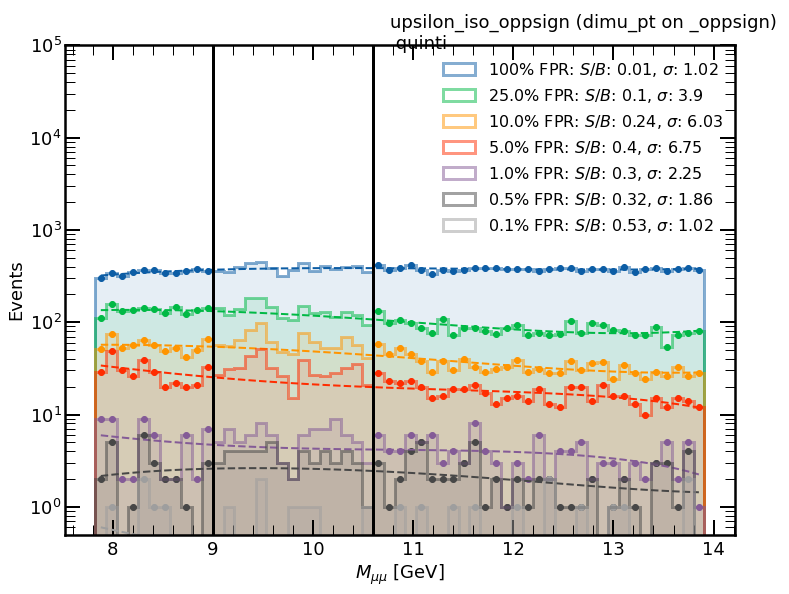

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

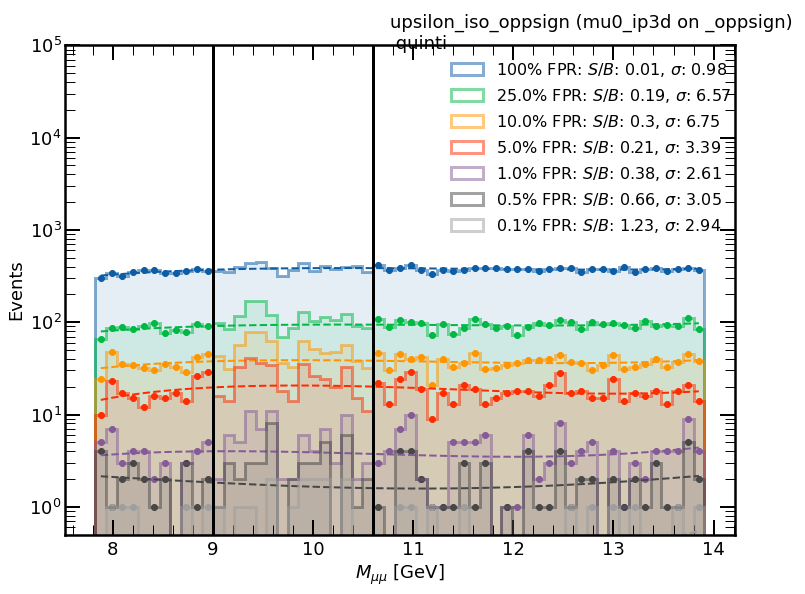

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

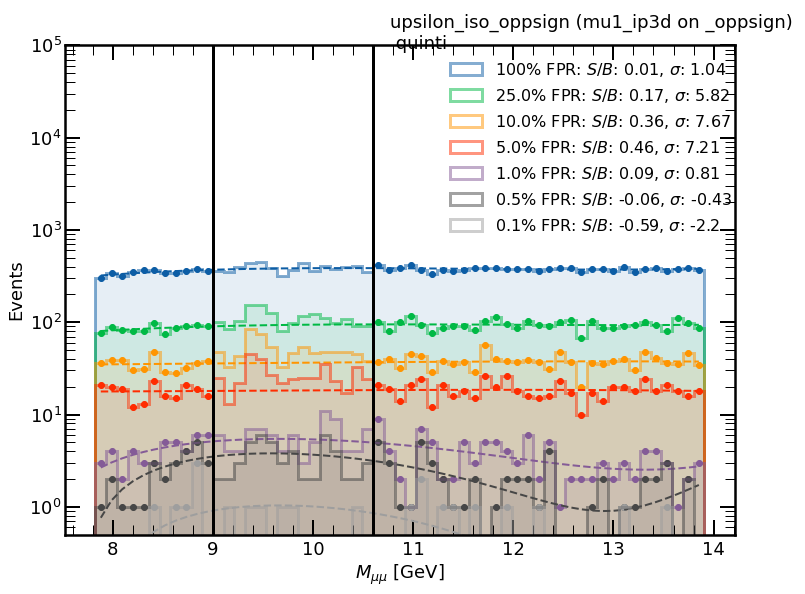

In [20]:
flip_features = [False, True, True]
for feature in feature_set[:-1]:
    print(feature)
    fpr_results_quintic = plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, fit_type, num_bins_SR, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])



# Plot ROC

In [21]:
"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 20)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)



# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, score_cutoffs):
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))

    for pseudo_e in range(num_pseudoexperiments):

        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(dataset_by_pseudo_e[pseudo_e][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = scores_by_pseudo_e[pseudo_e][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)

            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

            # TODO: ERRORS
            
            S_yield[t, pseudo_e] = num_S_expected_in_SR
            B_yield[t, pseudo_e] = num_B_expected_in_SR
        
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC



In [22]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_dict, mass_scalar, fit_type, num_bins_SR, title, SB_left, SR_left, SR_right, SB_right, flip = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """

    fpr_thresholds = np.linspace(0, 1, 100)[::-1]
    signal_yeilds = np.zeros((len(fpr_thresholds), 50))
    background_yields = np.zeros((len(fpr_thresholds), 50))
    background_errors = np.zeros((len(fpr_thresholds), 50))

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    for t, threshold in enumerate(fpr_thresholds):


        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        

        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        # To approximate the background error, use Gaussian noise
        s_variations = np.zeros(50)
        b_variations = 0*np.random.normal(0, B_error, 50)

        signal_yeilds[t, :] =  s_variations + num_S_expected_in_SR
        background_yields[t, :] = b_variations + num_B_expected_in_SR

        print(f"Threshold: {threshold}, S: {num_S_expected_in_SR   }, B: {num_B_expected_in_SR  }, TPR: {num_S_expected_in_SR/signal_yeilds[0,0]  }, FPR: {num_B_expected_in_SR/background_yields[0,0]}")   




    TPR = signal_yeilds/signal_yeilds[0, :]
    FPR = background_yields/background_yields[0, :]

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC


In [24]:

TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, score_cutoffs_finegrained)

feature_TPRs = {}
feature_FPRs = {}
feature_ROCs = {}
feature_SICs = {}

flip_features = [False, True, True]
for feature in feature_set[:-1]:
    print(feature)
    feature_TPRs[feature], feature_FPRs[feature], feature_ROCs[feature], feature_SICs[feature] = feature_cut_ROCS(feature, test_data_dict, scaler, fit_type, num_bins_SR, f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])


# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_TPRs["CATHODE"] = TPR
feature_FPRs["CATHODE"] = FPR
feature_ROCs["CATHODE"] = ROC
feature_SICs["CATHODE"] = SIC


On pseudo experiment 1...
On pseudo experiment 2...
On pseudo experiment 3...
On pseudo experiment 4...
On pseudo experiment 5...
On pseudo experiment 6...
On pseudo experiment 7...
On pseudo experiment 8...
On pseudo experiment 9...
On pseudo experiment 10...
On pseudo experiment 11...
On pseudo experiment 12...
On pseudo experiment 13...
On pseudo experiment 14...
On pseudo experiment 15...
On pseudo experiment 16...
On pseudo experiment 17...
On pseudo experiment 18...
On pseudo experiment 19...
On pseudo experiment 20...
On pseudo experiment 21...
On pseudo experiment 22...
On pseudo experiment 23...
On pseudo experiment 24...
On pseudo experiment 25...
On pseudo experiment 26...
On pseudo experiment 27...
On pseudo experiment 28...
On pseudo experiment 29...
On pseudo experiment 30...
On pseudo experiment 31...
On pseudo experiment 32...
On pseudo experiment 33...
On pseudo experiment 34...
On pseudo experiment 35...
On pseudo experiment 36...
On pseudo experiment 37...
On pseudo 

/tmp/ipykernel_2054695/2939447294.py:111: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_2054695/2939447294.py:130: RuntimeWarning: invalid value encountered in sqrt
  SIC = TPR/np.sqrt(FPR)


Threshold: 1.0, S: 78.62775939817857, B: 5734.372240601821, TPR: 1.0, FPR: 1.0
Threshold: 0.98989898989899, S: 68.03766578525756, B: 5691.962334214742, TPR: 0.8653135521859175, FPR: 0.9926042634472177
Threshold: 0.9797979797979799, S: 64.16238769040774, B: 5643.837612309592, TPR: 0.8160271662515933, FPR: 0.9842119373327031
Threshold: 0.9696969696969697, S: 67.27672950296437, B: 5580.723270497036, TPR: 0.8556358469057793, FPR: 0.9732056162979994
Threshold: 0.9595959595959597, S: 64.45395132549766, B: 5528.546048674502, TPR: 0.8197353176388585, FPR: 0.9641065868605493
Threshold: 0.9494949494949496, S: 74.42876181873817, B: 5469.571238181262, TPR: 0.9465964996131166, FPR: 0.9538221462942963
Threshold: 0.9393939393939394, S: 76.43296937036212, B: 5404.567030629638, TPR: 0.9720863211082765, FPR: 0.9424862572337002
Threshold: 0.9292929292929294, S: 80.67151169074714, B: 5365.328488309253, TPR: 1.025992757624172, FPR: 0.9356435653619449
Threshold: 0.9191919191919192, S: 84.7979026395551, B: 5

/tmp/ipykernel_2054695/2939447294.py:111: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)
/tmp/ipykernel_2054695/2939447294.py:130: RuntimeWarning: invalid value encountered in sqrt
  SIC = TPR/np.sqrt(FPR)


Threshold: 0.98989898989899, S: 99.97303074605406, B: 5665.026969253946, TPR: 1.1964306382810572, FPR: 0.9885848869888189
Threshold: 0.9797979797979799, S: 105.6485222117899, B: 5606.35147778821, TPR: 1.2643522750088407, FPR: 0.9783456234487714
Threshold: 0.9696969696969697, S: 114.71615473440215, B: 5546.283845265598, TPR: 1.3728694749553398, FPR: 0.9678634220344906
Threshold: 0.9595959595959597, S: 122.06586748106383, B: 5479.934132518936, TPR: 1.4608274116813695, FPR: 0.9562849558359374
Threshold: 0.9494949494949496, S: 154.7435005006646, B: 5410.256499499335, TPR: 1.8518980938382994, FPR: 0.9441257454141374
Threshold: 0.9393939393939394, S: 145.52624032486528, B: 5353.473759675135, TPR: 1.7415902198743063, FPR: 0.9342167796251509
Threshold: 0.9292929292929294, S: 151.96699780422205, B: 5307.033002195778, TPR: 1.8186702035912596, FPR: 0.9261125585449023
Threshold: 0.9191919191919192, S: 184.21662961786387, B: 5227.783370382136, TPR: 2.2046187667906154, FPR: 0.9122829706655153
Thresh

/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: invalid value encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/tmp/ipykernel_2054695/2939447294.py:110: RuntimeWarning: overflow encountered in double_scalars
  S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
/tmp/ipykernel_2054695/2939447294.py:128: RuntimeWarning: overflow encountered in divide
  ROC = 1.0/FPR


findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

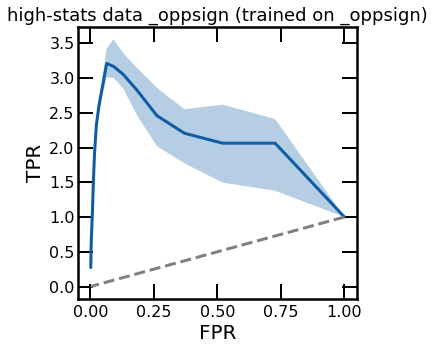

In [25]:
     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"high-stats data _oppsign (trained on {train_data_id_title})")
plt.show()



/global/homes/r/rmastand/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(0.0, 6.0)

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

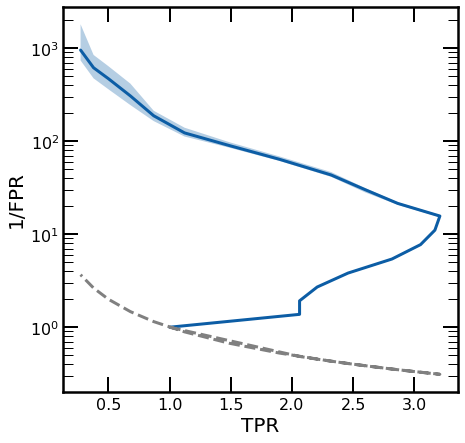

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

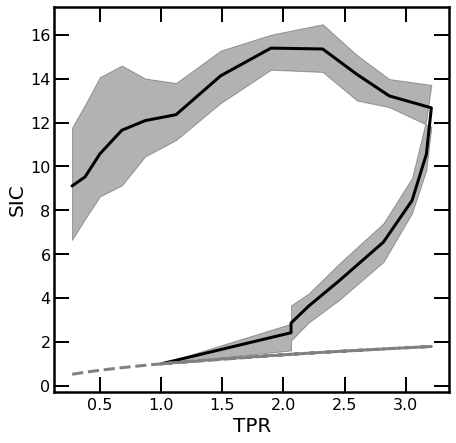

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

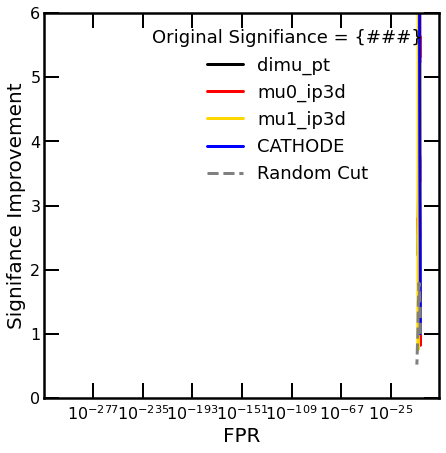

In [26]:

fig, ax = newplot("full", use_tex = latex_flag)
ax.plot(TPR_median, ROC_median)
ax.fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax.plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax.set_xlabel("TPR")
ax.set_ylabel("1/FPR")
ax.set_yscale("log")


fig, ax = newplot("full", use_tex = latex_flag)
ax.plot(TPR_median, SIC_median, color = "black")
ax.fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
ax.plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax.set_xlabel("TPR")
ax.set_ylabel("SIC")

# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["black", "red", "gold", "blue"]
for (i, key) in enumerate(feature_SICs.keys()):

    TPR_median, TPR_lower, TPR_upper = get_median_percentiles(feature_TPRs[key])
    FPR_median, FPR_lower, FPR_upper = get_median_percentiles(feature_FPRs[key])
    ROC_median, ROC_lower, ROC_upper = get_median_percentiles(feature_ROCs[key])
    SIC_median, SIC_lower, SIC_upper = get_median_percentiles(feature_SICs[key])

    ax.plot(FPR_median, SIC_median, color = colors[i], label = key)
    ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = colors[i])
ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Signifance Improvement")

legend_title = "Original Signifiance = {###}"
plt.legend(title = legend_title, loc = "upper right")
plt.xscale("log")
plt.ylim(0, 6)


# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)